<a href="https://colab.research.google.com/github/jkierzkowski/physics/blob/main/Q_Ideal_Gas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import quad
import scipy.constants as const
from math import inf
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from mpmath import polylog as polylog
import mpmath as mpf
import json
from google.colab import drive


Definitions:
  
*  $polylog(s, z) = ∑^∞_{n=1}\frac{z^n }{n^{s}}$ - mpmath polylog
*  $f_s(z) = -∑^∞_{n=1} \frac{(-z)^n }{n^{s}}$ - polylogarithm for Fermi ideal gas
*  $b_s(z)= \sum_{n=1}^∞ \frac{z^n}{n^s}$ - polylogarithm for Bose ideal gas
*  $λ =\sqrt{\frac{2πħ^2}{k_BTm}}$ - thermal wave lenght
*  $z = e^{µ/(k_BT)}$

Equations of state for Fermi gas:
*  $\frac{N}{V} = \frac{2s + 1}{λ^3}f_{3/2}(z)$,
*  $\frac{P}{k_BT} = \frac{2s + 1}{λ^3}f_{5/2}(z)$,

where $s$ is a spin of particle.


Equations of state for Bose gas:

*  $\frac{N}{V} = \frac{2s + 1}{λ^3}b_{3/2}(z) +\frac{2s+1}{V}\frac{z}{1 − z}$
*  $\frac{P}{k_BT} = \frac{2s + 1}{λ^3}b_{5/2}(z)$

The **Q_Ideal_Gas class** generates an object representing a Fermi or Bose ideal gas. To instantiate the object, the user must provide the mass m [kg], temperature T [mK], volume V [nm^3], spin s, and the number of particles N. The class calculates the gas pressure [E27 Pa] using equations above. The **Setz()** method determines the parameter z by solving the first equation, utilizing the **scipy.optimize.fsolve()** function. Subsequently, the **Calculate_p()** method computes the pressure based on the second equation.

Fermi gas at $T=0$

$P = \frac{2}{5} n \epsilon_F$, where $\epsilon_F = \left(\frac{3N}{4\pi (2s+1) V} \right)^{2/3} \frac{h^2}{2m}$

Estimated critical temperature for Bose ideal gas:

$T_c = 3.3125 \frac{\hbar^2n^{2/3}}{mk_B}$

In [ ]:
class Q_Ideal_Gas:

  """
  Units:
  mass [kg]
  temperature [mK]
  volume [m^3]
  pressure [E Pa]
  """

  def __init__(self, m, T, V, s, N):
    self.m = m # Mass
    self.T = T # Temperature in K
    self.V = V # Volume in m^3
    self.s = s # spin
    self.B_or_F = -1 if (s * 2)%2==0  else 1
    self.N = N # Number of particles
    self.z = 0. # e^(mu/(k_BT))
    self.p = 0. # Pressure
    self.k_b = const.k * 1e3 #factor 1e3 reduces 'z'
    self.l = const.h/np.sqrt(2*np.pi*self.m*self.T*self.k_b) #thermal wave lenght
    # Functions that calculates z and pressure
    self.Setz()
    self.Setp()

  def display(self):
    print(f"Particle mass: [{self.m}]")
    print(f"Number of particles: [{self.N}]")
    print(f"Temperature: [{self.T}]")
    print(f"Volume: [{self.V}]")
    print(f"Spin: [{self.s}]")
    print(f"z: [{self.z}]")
    print(f"Pressure: [{self.p}]")
    print(f"Bosons(-1) or Fermions(1): [{self.B_or_F}]")

  def SetT(self, T):
    self.T = T

  def SetV(self, V):
    self.V = V

  def Setp(self, p=0.):
    if(p == 0.):
      self.Setz()
      self.Calculate_p()
    else:
      self.p = p

  #taking real part of polylogarithm
  def real_polylog(s,k):
    return(polylog(s,k).real)

  @staticmethod
  def equation_for_z_fermi(z, l, sm, n):
    np_polylog = np.frompyfunc(Q_Ideal_Gas.real_polylog,2,1) #fuction, number of input arguments, and number of output arguments
    return -sm/l**3*float(np_polylog(1.5, -1*np.squeeze(z))) - n

  @staticmethod
  def equation_for_z_bose(z, l, sm, n, V):
    np_polylog = np.frompyfunc(Q_Ideal_Gas.real_polylog,2,1) #fuction, number of input arguments, and number of output argumets
    return sm/l**3*float(np_polylog(1.5, np.squeeze(z))) + sm/V*z/(1-z) - n

  def initial_z(self):
    nq=self.m*self.k_b*self.T/const.hbar**2/2/np.pi
    return self.N/self.V/nq**(1.5)

  def Setz(self):
    n = self.N/self.V
    initial_guess = self.initial_z()
    sm = (2*self.s+1)
    self.z = fsolve(self.equation_for_z_fermi, initial_guess, args=(self.l,sm,n))[0]\
    if self.B_or_F==1 else fsolve(self.equation_for_z_bose, initial_guess, args=(self.l,sm,n,self.V))[0]

  def Calculate_p(self):
    np_polylog = np.frompyfunc(Q_Ideal_Gas.real_polylog,2,1)
    z = self.z
    l3 = self.l**3
    sm = 2*self.s+1
    if(self.B_or_F == -1):
      self.p = sm/l3*np_polylog(2.5,z)*self.k_b*self.T
    else:
      self.p = -(sm)/l3*np_polylog(2.5,-z)*self.k_b*self.T

The Q_Isotherm(Q_Ideal_Gas) class generates an object representing an isothermal transformation for a given quantum ideal gas. User need to provide the mass of the particle (m), temperature (T), volumes between which the process will be calculated (V1, V2), spin of the particle (s), number of particles (N), and resolution (nbin, indicating how many points between volumes).

In [ ]:
class Q_Isotherm(Q_Ideal_Gas):

  def __init__(self, m, T, V1, V2, s, N, nbin):
    super().__init__(m, T, V1,s,N)
    self.nbin = nbin
    self.V1 = min(V1, V2)
    self.V2 = max(V1, V2)
    self.p_vec = []
    self.V_vec = []
    self.mu_vec = []
    self.SetV_vec()
    self.Setp_vec()

  def display(self):
    print(f"Particle mass: [{self.m}]")
    print(f"Number of particles: [{self.N}]")
    print(f"Temperature: [{self.T}]")
    print(f"Volume range: [{self.V_vec[0]} - {self.V_vec[-1]}]")
    print(f"Spin: [{self.s}]")
    print(f"Pressure range: [{self.p_vec[0]} - {self.p_vec[-1]}]")
    print(f"Bosons(-1) or Fermions(1): [{self.B_or_F}]")
    print(f"Percent of integration failure: [{self.how_bad()*100}%]")
    plt.scatter(self.V_vec, self.p_vec, label="p(V)",s=3)
    plt.xlabel('V')
    plt.ylabel('p')
    plt.legend()
    plt.show()

  def SetV_vec(self):
    V1, V2 = min(self.V1, self.V2), max(self.V1, self.V2)
    self.V_vec = np.linspace(V1, V2, nbin)

  def Setp_vec(self):
    for Vi in self.V_vec:
      self.SetV(Vi)
      self.Setz()
      self.Setp()
      self.p_vec.append(self.p)
      self.mu_vec.append(np.log(self.z)*self.k_b*self.T)

#how many integrations fails
  def how_bad(self):
    x = 0
    for i in range(self.nbin):
      if(np.isnan(float(self.p_vec[i]))): x+=1
    return(x/nbin)


In [ ]:
"""
Units:
mass [kg]
temperature [mK]
volume [m^3]
pressure [E27 Pa]
"""
#p(V) Fermions(Rubidium)
N, V1, V2, T, Fm, Fs, nbin = 10E11, 1.75e-19, 5e-19, 0.1, 1.4192261E-25, 1/2, 100

T=0.5e-3
Fisotherm = Q_Isotherm(Fm,T,V1,V2,Fs,N,nbin)

#Fermions at T = 0
VF0 =  np.linspace(V1,V2,nbin)
PF0 = 0.4 * N / VF0 * (3. * N / 4. / np.pi /(2. * Fs + 1.) / VF0) ** (2. / 3.) * const.h**2 / 2. / Fm


#p(V) Bosons(Z)
Bm, Bs = 1.625565545866e-25, 0
Bisotherm = Q_Isotherm(Bm,T,V1,V2,Bs,N,nbin)


#p(V) classic
V_cl = np.linspace(V1,V2,nbin)
p_cl = N*const.k*T/V_cl*1e3

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


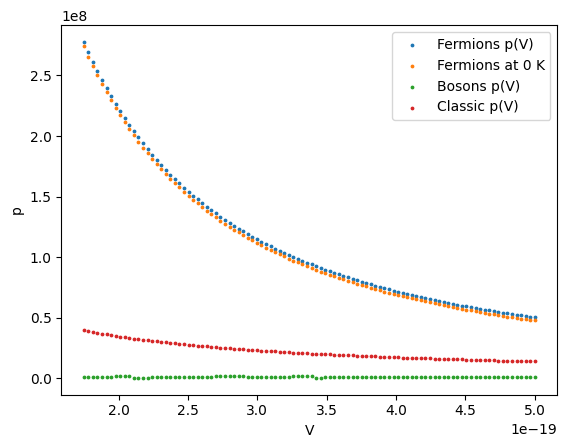

In [ ]:
#plt.scatter(Fisotherm.V_vec, Fisotherm.A_vec, label="Fermions A(V)",s=3)
plt.scatter(Fisotherm.V_vec, Fisotherm.p_vec, label="Fermions p(V)",s=3)
plt.scatter(VF0, PF0, label = "Fermions at 0 K", s=3)
#Fisotherm.display()
plt.scatter(Bisotherm.V_vec, Bisotherm.p_vec, label="Bosons p(V)",s=3)
#Bisotherm.display()
plt.scatter(V_cl,p_cl, label="Classic p(V)",s=3)
plt.xlabel('V')
plt.ylabel('p')
plt.legend()
plt.show()

In [ ]:
np.exp(np.array(Bisotherm.mu_vec)/(Fisotherm.T*Fisotherm.k_b))

The Q_Isentropic(Q_Ideal_Gas) class generates an object representing an isentropic transformation for a given quantum ideal gas. User need to provide the mass of the particle (m), volume (V), temperatures between which the process will be calculated (T1, T2), spin of the particle (s), number of particles (N), and resolution (nbin, indicating how many points between volumes).

In [ ]:
class Q_Isentropic(Q_Ideal_Gas):

  def __init__(self, m, T1, T2, V, s, N, nbin):
    super().__init__(m, T1, V,s,N)
    self.T1 = max(T1, T2)
    self.T2 = min(T1, T2)
    self.nbin = nbin
    self.p_vec = []
    self.V_vec = []
    self.T_vec = []
    self.SetT_vec()
    self.Setp_and_V_vecs()

  def display(self):
    print(f"Particle mass: [{self.m}]")
    print(f"Number of particles: [{self.N}]")
    print(f"Temperature: [{self.T}]")
    print(f"Volume range: [{self.V_vec[0]} - {self.V_vec[-1]}]")
    print(f"Spin: [{self.s}]")
    print(f"z: [{self.z}]")
    print(f"Pressure range: [{self.p_vec[0]} - {self.p_vec[-1]}]")
    print(f"Bosons(-1) or Fermions(1): [{self.B_or_F}]")
    print(f"Percent of integration failure: [{self.how_bad()*100}%]")

  def SetT_vec(self):
    self.T_vec = np.linspace(self.T1, self.T2, nbin)

  def Setp_and_V_vecs(self):
    Vconst, pconst = self.V*self.T**1.5,self.p*self.T**(-2.5)
    for Ti in self.T_vec:
      self.V_vec.append(Vconst*Ti**(-1.5))
      self.p_vec.append(pconst*Ti**2.5)
  def how_bad(self):
    x = 0
    for i in range(self.nbin):
      if(np.isnan(float(self.p_vec[i]))): x+=1
    return(x/nbin)

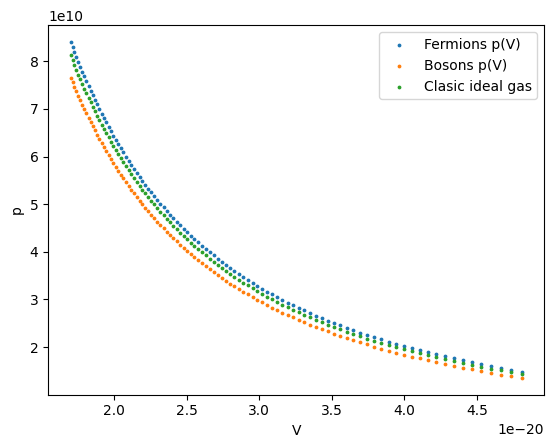

In [ ]:
#p(V) Fermions(Rubidium)
N, V, T1, T2, Fm, Fs, nbin = 10E11, 0.17e-19, 1e-1, 5e-2, 1.4192261E-25, 1/2, 100
Fisentrop = Q_Isentropic(Fm,T1,T2,V,Fs,N,nbin)

#p(V) Bosons
Bm, Bs = 1.625565545866e-25, 0
Bisentrop = Q_Isentropic(Bm,T1,T2,V,Bs,N,nbin)

#classic Isentropic process
T_cl = np.linspace(T1,T2,nbin)
p1 = N * const.k * 1e3 * T1 / V
Vconst, pconst = V*T1**1.5, p1*T1**(-2.5)
V_cl = Vconst*T_cl**-1.5
p_vec = pconst*T_cl**2.5

plt.scatter(Fisentrop.V_vec, Fisentrop.p_vec, label="Fermions p(V)",s=3)
plt.scatter(Bisentrop.V_vec, Bisentrop.p_vec, label="Bosons p(V)",s=3)
plt.scatter(V_cl, p_vec, label="Clasic ideal gas", s=3)
plt.xlabel('V')
plt.ylabel('p')
#plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
class Q_Isochoric(Q_Ideal_Gas):

  def __init__(self, m, T1, T2, V, s, N, nbin):
    super().__init__(m, T1, V,s,N)
    self.nbin = nbin
    self.T1 = max(T1, T2)
    self.T2 = min(T1, T2)
    self.p_vec = []
    self.V_vec = np.full(nbin,V)
    self.mu_vec = []
    self.SetT_vec()
    self.Setp_vec()


  def display(self):
    print(f"Particle mass: [{self.m}]")
    print(f"Number of particles: [{self.N}]")
    print(f"Temperature: [{self.T}]")
    print(f"Volume range: [{self.V_vec[0]} - {self.V_vec[-1]}]")
    print(f"Spin: [{self.s}]")
    print(f"Pressure range: [{self.p_vec[0]} - {self.p_vec[-1]}]")
    print(f"Bosons(-1) or Fermions(1): [{self.B_or_F}]")
    print(f"Percent of integration failure: [{self.how_bad()*100}%]")
    plt.scatter(self.V_vec, self.p_vec, label="p(V)",s=3)
    plt.xlabel('V')
    plt.ylabel('p')
    plt.legend()
    plt.show()

  def SetT_vec(self):
    T1, T2 = min(self.T1, self.T2), max(self.T1, self.T2)
    self.T_vec = np.linspace(T1, T2, nbin)

  def Setp_vec(self):
    for Ti in self.T_vec:
      self.SetT(Ti)
      self.Setz()
      self.Setp()
      self.p_vec.append(self.p)
      self.mu_vec.append(np.log(self.z)*self.k_b*self.T)

#how many integrations fails
  def how_bad(self):
    x = 0
    for i in range(self.nbin):
      if(np.isnan(float(self.p_vec[i]))): x+=1
    return(x/nbin)

Critical temperature  = 28436.36343326913 mK


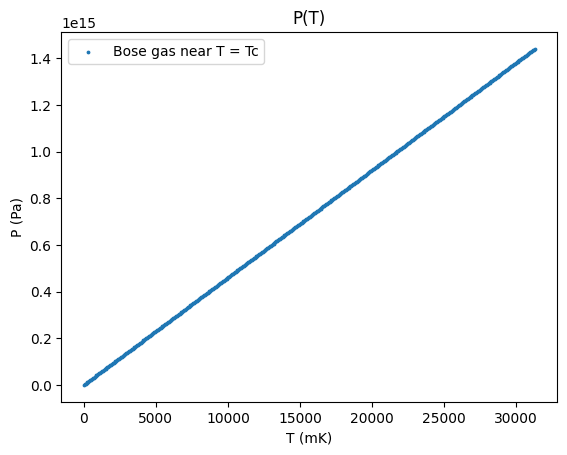

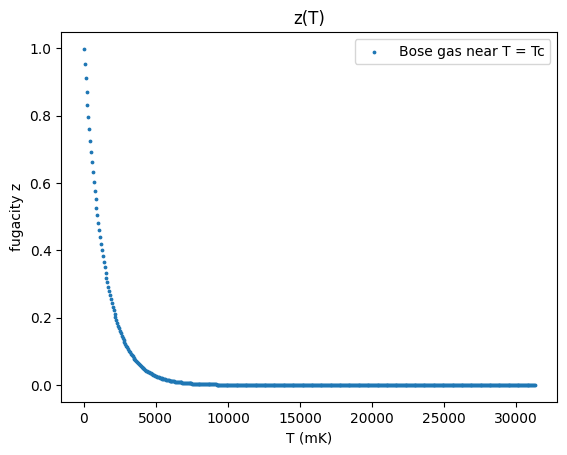

In [ ]:
#Checking how results break down when  T => Tc for bosons => z->1
m = 1.4192261E-25
Tc = 3.3125*const.hbar**2*(N/V)**(2/3)/m/const.k*1e3
print(f"Critical temperature  = {Tc} mK")
N, V, T1, T2,  s, nbin = 10E11, 3.e-19, 1.1*Tc, 0.0001*Tc, 0, 500

BGas = Q_Isochoric(m, T1, T2, V, s, N,nbin)
plt.scatter(BGas.T_vec,BGas.p_vec,label  = "Bose gas near T = Tc", s=3)
plt.xlabel("T (mK)")
plt.ylabel("P (Pa)")
plt.legend()
plt.title("P(T)")
plt.show()
plt.scatter(BGas.T_vec,np.exp(np.array(BGas.mu_vec)/(BGas.T*BGas.k_b)),label= "Bose gas near T = Tc",s=3)
plt.xlabel("T (mK)")
plt.ylabel("fugacity z")
plt.legend()
plt.title("z(T)")
plt.show()


In [ ]:
N, V, T1, T2, Fm, Fs, nbin = 10E11, 0.17e-19, 1e-1, 5e-2, 1.4192261E-25, 1/2, 100
#Fermions
Fisochoric = Q_Isochoric(Fm,T1,T2,V,Fs,N,nbin)

#Bosons
Bm, Bs = 1.625565545866e-25, 0
Bisochoric = Q_Isochoric(Bm,T1,T2,V,Bs,N,nbin)

#classic
T_cl = np.linspace(T1,T2,nbin)
p_cl = T_cl*N*const.k*1e3/V



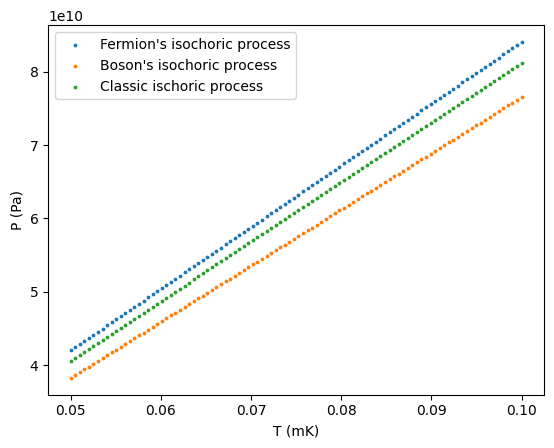

In [ ]:
plt.scatter(Fisochoric.T_vec, Fisochoric.p_vec,label = "Fermion's isochoric process",s = 3)
plt.scatter(Bisochoric.T_vec, Bisochoric.p_vec,label = "Boson's isochoric process",s = 3)
plt.scatter(T_cl,p_cl,label = "Classic ischoric process", s = 3)
plt.xlabel("T (mK)")
plt.ylabel("P (Pa)")
plt.legend()

The Q_Carnot class takes **Q_Isotherm** and **Q_Isentropic** objects to define the Carnot cycle. The defining objects should represent the two first proceses, e.i., the isothermal process occurring at higher temperature and the isentropic one originating from higher temperatures and greater volumes.

An object of the Q_Carnot class calculates two consecutive transformations  within the Carnot cycle.
The **efficiency()** function is designed to return the efficiency of both the quantum and classical Carnot engine cycles.


In [ ]:
class Q_Carnot(Q_Isotherm,Q_Isentropic):
  def __init__(self, isothermal1, isentropic1):
    self.m, self.s, self.N, self.nbin = isothermal1.m, isothermal1.s, isothermal1.N, isothermal1.nbin
    self.k_b = const.k*1e3
    self.isothermal1 = isothermal1
    self.isentropic1 = isentropic1
    self.isentropic2 = Q_Isentropic(self.m, isentropic1.T1, isentropic1.T2, isothermal1.V1, self.s, self.N,self.nbin)
    self.isothermal2 = Q_Isotherm(self.m, isentropic1.T2, self.isentropic2.V_vec[-1], isentropic1.V_vec[-1], self.s, self.N, self.nbin)
    self.Tmax = self.isentropic1.T1
    self.Tmin = self.isentropic1.T2
    self.Vmin = self.isothermal1.V1
    self.Vmax = self.isentropic1.V_vec[-1]
  #calculating total work of the cycle
  def calculate_total_work(self):
    processes_Wp  = [self.isothermal1, self.isentropic1]
    processes_Wm = [self.isentropic2,self.isothermal2]
    W = 0
    for process in processes_Wp:
      W += np.trapz(process.p_vec, process.V_vec)
    for process in processes_Wm:
      W -= np.trapz(process.p_vec, process.V_vec)
    return(W)

  #simplyfied classic ideal gas model
  def calculate_classic(self):
    V1, V2 = self.isothermal1.V_vec[0], self.isothermal1.V_vec[-1]
    T1, T2 = self.isothermal1.T, self.isothermal2.T
    #isothermal process
    V1_cl = np.linspace(V1,V2,self.nbin)
    p1_cl = self.N*self.k_b*T1/V1_cl
    #isentropic process
    T_cl = np.linspace(T1,T2,nbin)
    Vconst1, pconst1 = V1*T1**1.5, p1_cl[0]*T1**(-2.5)
    V1_isen = Vconst1*T_cl**-1.5
    p1_isen = pconst1*T_cl**2.5
    #isentropic process
    Vconst2, pconst2 = V2*T1**1.5, p1_cl[-1]*T1**(-2.5)
    V2_isen = Vconst2*T_cl**-1.5
    p2_isen = pconst2*T_cl**2.5
    #isothermal process
    V3_cl = np.linspace(V1_isen[-1], V2_isen[-1], self.nbin)
    p3_cl = self.N*self.k_b*T2/V3_cl
    return(V1_cl,p1_cl,V1_isen,p1_isen,V3_cl,p3_cl,V2_isen,p2_isen)

  def efficiency(self):
    W = self.calculate_total_work()
    Qh = np.trapz(self.isothermal1.p_vec, self.isothermal1.V_vec)
    return (f"Quantum: {float(W/Qh)}, Classic: {1-self.Tmin/self.Tmax}")

  def display(self,title = "" ,save = False, fname = "QCarnotCyclePlot"):
    print(f"V1 - V2 => {self.Vmin} -{self.Vmax}")
    print(f"T1 - T2 => {self.Tmin} - {self.Tmax}")
    print(f"Engine efficiencies => {self.efficiency()}")
    print(f"Number of particle, mass, and spin N = {self.N}, m = {self.m} s = {self.s}")
    plt.scatter(self.isothermal1.V_vec,self.isothermal1.p_vec,s = 4, label="Isothermal process")#,c="red")
    plt.scatter(self.isentropic1.V_vec, self.isentropic1.p_vec, s = 4,label="Isentropic process")#,c="red")
    plt.scatter(self.isothermal2.V_vec, self.isothermal2.p_vec, s = 4,label="Isothermal process")#, c="red")
    plt.scatter(self.isentropic2.V_vec, self.isentropic2.p_vec, s = 4,label="Isentropic process")#, c="red")
    plt.legend()
    plt.title(title)
    plt.xlabel("V (m^3)")
    plt.ylabel("P (Pa)")
    if(save):
      plt.savefig(fname)
    plt.show()

V1 - V2 => 0.1 -2.598076211353315
T1 - T2 => 0.1 - 0.3
Engine efficiencies => Quantum: 0.6666666666666667, Classic: 0.6666666666666666
Number of particle, mass, and spin N = 1000000000.0, m = 1.4192261e-25 s = 2.5


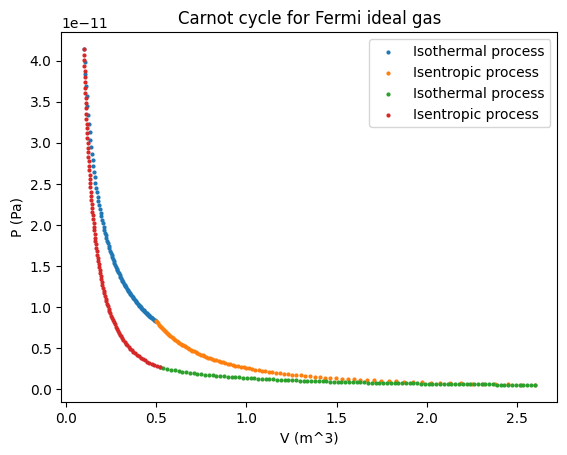

V1 - V2 => 0.1 -2.598076211353315
T1 - T2 => 0.1 - 0.3
Engine efficiencies => Quantum: 0.6666666666666669, Classic: 0.6666666666666666
Number of particle, mass, and spin N = 1000000000.0, m = 1.4192261e-25 s = 0


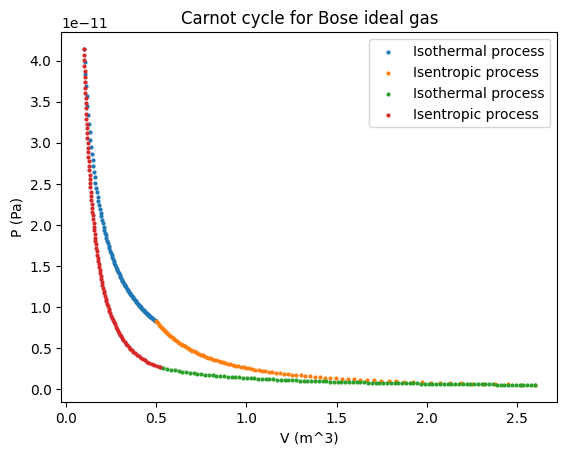

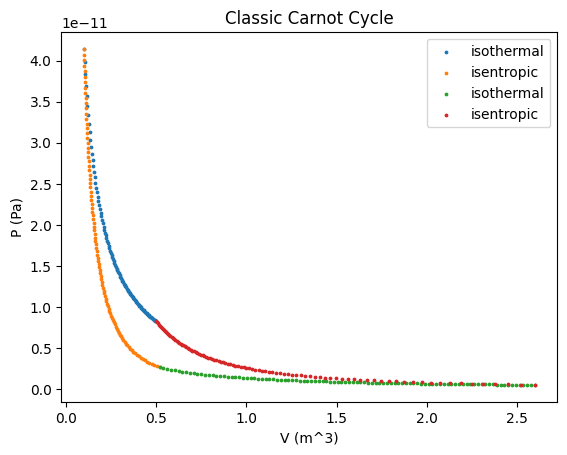

In [ ]:
N, V1, V2, T1, T2, Fm, Fs, nbin = 10E8, 0.1, 0.5, 0.3, 0.1, 1.4192261E-25, 2.5, 100
Fisotherm1 = Q_Isotherm(Fm,T1, V1, V2, Fs, N, nbin)
Fisentrop1 = Q_Isentropic(Fm, T1, T2, V2, Fs, N, nbin)
Fcarnot = Q_Carnot(Fisotherm1, Fisentrop1)

Fcarnot.display("Carnot cycle for Fermi ideal gas")

Bs = 0
Bisotherm1 = Q_Isotherm(Fm,T1, V1, V2, Bs, N, nbin)
Bisentrop1 = Q_Isentropic(Fm, T1, T2, V2, Bs, N, nbin)
Bcarnot = Q_Carnot(Bisotherm1, Bisentrop1)
Bcarnot.display("Carnot cycle for Bose ideal gas")

carnot_cl = Fcarnot.calculate_classic()
plt.scatter(carnot_cl[0],carnot_cl[1],label = "isothermal",s = 3)
plt.scatter(carnot_cl[2],carnot_cl[3],label = "isentropic",s = 3)
plt.scatter(carnot_cl[4],carnot_cl[5],label = "isothermal",s = 3)
plt.scatter(carnot_cl[6],carnot_cl[7],label = "isentropic",s = 3)
plt.title("Classic Carnot Cycle")
plt.xlabel("V (m^3)")
plt.ylabel("P (Pa)")
plt.legend()
plt.show()

The **Q_Otto** class takes two objects: **Q_Isentropic** (representing the process at the higher temperature) and **Q_Isochoric** (representing the process at the smaller volume). It then creates two additional objects representing the isentropic process at the lower temperature and the isochoric process at the greater volume. The functions of the **Q_Otto** class can plot (**display()**) P(V) curves and calculate the efficiency of the cycle. Additionally, it provides a function for calculating the p(V) of the Otto cycle for a monoatomic classical ideal gas."

In [ ]:
class Q_Otto(Q_Isentropic,Q_Isochoric):
  def __init__(self,isentropic1,isochoric1):
    self.isentropic1 = isentropic1
    self.isochoric1 = isochoric1
    self.k_b = const.k*1e3
    self.T1 = self.isentropic1.T1
    self.T2 = self.isentropic1.T2
    self.T3 = self.isochoric1.T2
    self.Vmax = self.isentropic1.V_vec[0]
    self.Vmin = self.isentropic1.V_vec[-1]
    self.T4 = (self.Vmax*self.T3**1.5/self.Vmin)**(2/3)
    self.s = self.isentropic1.s
    self.N = self.isentropic1.N
    self.nbin =self.isentropic1.nbin
    self.m = self.isentropic1.m
    self.isentropic2 = Q_Isentropic(self.m, self.T3, self.T4, self.Vmax, self.s, self.N, self.nbin)
    self.isochoric2 = Q_Isochoric(self.m, self.T2, self.T4, self.Vmin, self.s, self.N, self.nbin)
    #simplyfied classic ideal gas model
  def calculate_classic(self):
    #isentropic process
    p1 = self.N*self.k_b*self.T1/self.Vmin
    T1_isen = np.linspace(self.T1,self.T2,self.nbin)
    Vconst1, pconst1 = self.Vmin*T1**1.5, p1*self.T1**(-2.5)
    V1_isen = Vconst1*T1_isen**-1.5
    p1_isen = pconst1*T1_isen**2.5
    #isochoric process
    T1_isoch = np.linspace(self.T1,self.T3,self.nbin)
    p1_isoch = self.N*self.k_b/V1_isen[0]*T1_isoch
    V1_isoch = np.full(self.nbin,V1_isen[0])
    #isochoric process
    T2_isoch = np.linspace(self.T2,self.T4,self.nbin)
    p2_isoch = self.N*self.k_b/V1_isen[-1]*T2_isoch
    V2_isoch = np.full(self.nbin,V1_isen[-1])
    #isentropic process
    T2_isen = np.linspace(self.T3,self.T4,self.nbin)
    p2 = self.N*self.k_b*self.T3/self.Vmin
    Vconst1, pconst1 = self.Vmin*T3**1.5, p2*self.T3**(-2.5)
    V2_isen = Vconst1*T2_isen**-1.5
    p2_isen = pconst1*T2_isen**2.5
    return(V1_isen,p1_isen,V1_isoch,p1_isoch,V2_isen,p2_isen, V2_isoch,p2_isoch)
  def efficiency(self):
    Ql = np.trapz(self.isochoric2.p_vec, self.isochoric2.T_vec)
    Qh = np.trapz(self.isochoric1.p_vec, self.isochoric1.T_vec)
    nu_cl = (self.T1-self.T4)/(self.T2-self.T3) - 1
    return(f"Quantum: {1-Ql/Qh} Classic: {nu_cl}")

  def display(self, title = "",save = False, name = "QOttoCyclePlot"):
    print(f"V1 - V2 => {self.Vmin} -{self.Vmax}")
    print(f"T1, T2, T3 , T4 => {self.T1}, {self.T2}, {self.T3}, {self.T4}")
    print(f"Engine efficiencies => {self.efficiency()}")
    print(f"Number of particle, mass, and spin N = {self.N}, m = {self.m} s = {self.s}")
    plt.scatter(self.isentropic1.V_vec, self.isentropic1.p_vec, s = 4,label="Isentropic process")
    plt.scatter(self.isentropic2.V_vec, self.isentropic2.p_vec, s = 4,label="Isentropic process")
    plt.scatter(self.isochoric1.V_vec, self.isochoric1.p_vec, s = 4,label="Isochoric process")
    plt.scatter(self.isochoric2.V_vec, self.isochoric2.p_vec, s = 4,label="Isochoric process")
    plt.title(title)
    plt.xlabel("V (m^3)")
    plt.ylabel("P (Pa)")
    plt.legend()
    if(save):
      plt.savefig(name)
    plt.show()


In [ ]:
N, T1, T2, T3, Fm, Fs, nbin = 10E8, 0.08, 0.06, 0.02, 1.4192261E-25, 2.5, 100
Fisentrop1 = Q_Isentropic(Fm,T1, T2, V1, Fs, N, nbin)
Fisochoric1 = Q_Isochoric(Fm, T1, T3, V1, Fs, N, nbin)
Fotto = Q_Otto(Fisentrop1,Fisochoric1)

Bs = 0
Bisentrop1 = Q_Isentropic(Fm,T1, T2, V1, Bs, N, nbin)
Bisochoric1 = Q_Isochoric(Fm, T1, T3, V1, Bs, N, nbin)
Botto = Q_Otto(Bisentrop1,Bisochoric1)


V1 - V2 => 0.1539600717839002 -0.1
T1, T2, T3 , T4 => 0.08, 0.06, 0.02, 0.015000000000000003
Engine efficiencies => Quantum: 0.63464553277844 Classic: 0.6250000000000002
Number of particle, mass, and spin N = 1000000000.0, m = 1.4192261e-25 s = 2.5


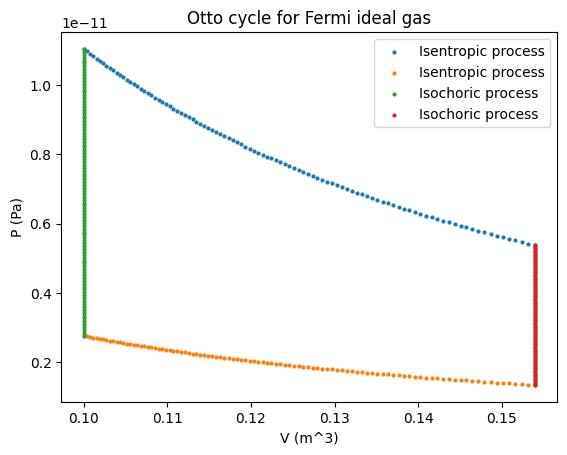

V1 - V2 => 0.1539600717839002 -0.1
T1, T2, T3 , T4 => 0.08, 0.06, 0.02, 0.015000000000000003
Engine efficiencies => Quantum: 0.63464553277844 Classic: 0.6250000000000002
Number of particle, mass, and spin N = 1000000000.0, m = 1.4192261e-25 s = 0


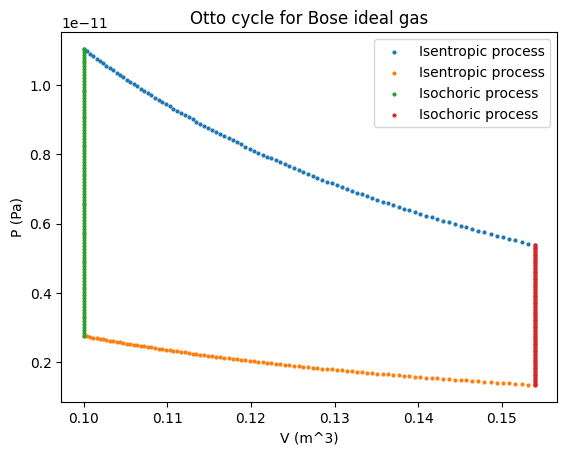

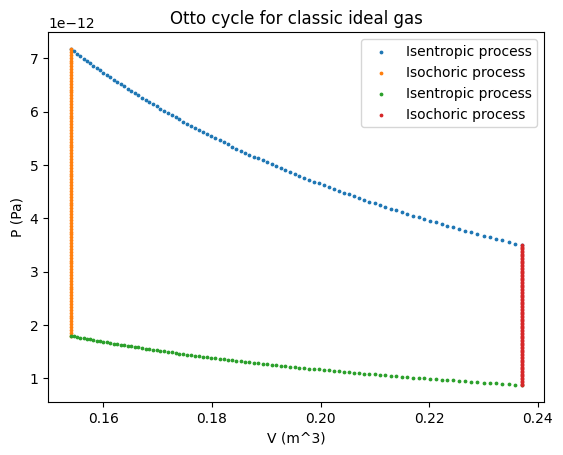

In [ ]:
Fotto.display("Otto cycle for Fermi ideal gas")
Botto.display("Otto cycle for Bose ideal gas")
v = Fotto.calculate_classic()
plt.scatter(v[0],v[1],s=3, label = "Isentropic process")
plt.scatter(v[2],v[3],s=3, label = "Isochoric process")
plt.scatter(v[4],v[5],s=3, label = "Isentropic process")
plt.scatter(v[6],v[7],s=3, label = "Isochoric process")
plt.xlabel("V (m^3)")
plt.ylabel("P (Pa)")
plt.title("Otto cycle for classic ideal gas")
plt.legend()

By using the code below you can mount Google Drive to Colab and directly save all your generated files.

In [ ]:
#drive.mount('/content/drive') #uncomment at first use to mount your Google drive
!cp file_name /path/to/Google_Drive_folder #copy generated file to destination on Google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
